In [1]:
import os
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
from tqdm import tqdm
from datetime import datetime

import tensorflow as tf

In [2]:
IMG_PATH = '../Data/PBC_base_Masks/Images'
MASK_PATH = '../Data/PBC_base_Masks/Label'

input_img_paths = sorted(
    [
        os.path.join(IMG_PATH, fname)
        for fname in os.listdir(IMG_PATH)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
masks_img_paths = sorted(
    [
        os.path.join(MASK_PATH, fname)
        for fname in os.listdir(MASK_PATH)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

df = pd.DataFrame(zip(input_img_paths, masks_img_paths), columns=['image_path', 'mask_path'])
df.to_csv('df.csv')
df.head()

,image_path,mask_path
0,../Data/PBC_base_Masks/Images/BA_100102.png,../Data/PBC_base_Masks/Label/label_BA_100102.png
1,../Data/PBC_base_Masks/Images/BA_101381.png,../Data/PBC_base_Masks/Label/label_BA_101381.png
2,../Data/PBC_base_Masks/Images/BA_101611.png,../Data/PBC_base_Masks/Label/label_BA_101611.png
3,../Data/PBC_base_Masks/Images/BA_102039.png,../Data/PBC_base_Masks/Label/label_BA_102039.png
4,../Data/PBC_base_Masks/Images/BA_102750.png,../Data/PBC_base_Masks/Label/label_BA_102750.png


In [3]:
def mask_thresh(mask_image):
    _, mask = cv2.threshold(mask_image, 0, 1, cv2.THRESH_BINARY)
    mask = np.expand_dims(mask, -1)
    return mask

In [4]:
IMG_SHAPE = 128
BATCH_SIZE = 32

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #validation_split=0.2,
    preprocessing_function=lambda x: x/255
)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #fill_mode="constant",
    #cval=2
    #validation_split=0.2,
    preprocessing_function=lambda x: mask_thresh(x)
)

image_train_generator = image_datagen.flow_from_dataframe(
    dataframe=df,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    interpolation='bicubic',
    x_col='image_path',
    class_mode=None,
    shuffle=False
)
mask_train_generator = mask_datagen.flow_from_dataframe(
    dataframe=df,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    interpolation='bicubic',
    x_col='mask_path',
    class_mode=None,
    color_mode='grayscale',
    shuffle=False
)
""" image_val_generator = image_datagen.flow_from_dataframe(
    dataframe=df,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    interpolation='bicubic',
    x_col='image_path',
    class_mode=None,
    shuffle=False,
    subset='validation'
)
mask_val_generator = mask_datagen.flow_from_dataframe(
    dataframe=df,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    interpolation='bicubic',
    x_col='mask_path',
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,
    subset='validation'
) """

train_ds = zip(image_train_generator, mask_train_generator)
#val_ds = zip(image_val_generator, mask_val_generator)

Found 1134 validated image filenames.
Found 1134 validated image filenames.


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

nb_class = 2

inputs = Input((128,128,3))
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(nb_class, 1, activation = 'softmax')(conv9)

model = Model(inputs = inputs, outputs = conv10)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-21 11:53:35.341215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-21 11:53:35.341608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [49]:
# Compile with a decremental optimizer
# lr decrease by a factor of 0.5 every 30 epoch
def lr_step_decay(epoch, lr):
    initial_learning_rate = 1e-2
    drop_rate = 0.8
    epochs_drop = 8
    lr = initial_learning_rate * np.power(drop_rate, np.floor(epoch/epochs_drop))
    return lr

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['SparseCategoricalAccuracy'])

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['SparseCategoricalAccuracy'])

In [7]:
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard --logdir logs
callbacks = [#tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
             #tf.keras.callbacks.LearningRateScheduler(lr_step_decay),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


2023-04-21 11:56:23.849274: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-21 11:56:24.619624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 30s 275ms/step - loss: 0.2185 - sparse_categorical_accuracy: 0.9162
Epoch 2/30
100/100 [==============================] - 27s 266ms/step - loss: 0.1590 - sparse_categorical_accuracy: 0.9474
Epoch 3/30
100/100 [==============================] - 27s 268ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9661
Epoch 4/30
100/100 [==============================] - 26s 263ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9649
Epoch 5/30
100/100 [==============================] - 27s 266ms/step - loss: 0.1128 - sparse_categorical_accuracy: 0.9709
Epoch 6/30
100/100 [==============================] - 26s 260ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9679
Epoch 7/30
100/100 [==============================] - 28s 278ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9752
Epoch 8/30
100/100 [==============================] - 27s 269ms/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9740
Epoch 9/30
100/100 [===============

In [8]:
model.save('../Models/UNET_masks.h5')

In [11]:
print('Accuracy :', history.history['sparse_categorical_accuracy'][-1])
print('Loss :', history.history['loss'][-1])

Accuracy : 0.9961060881614685
Loss : 0.009555608965456486


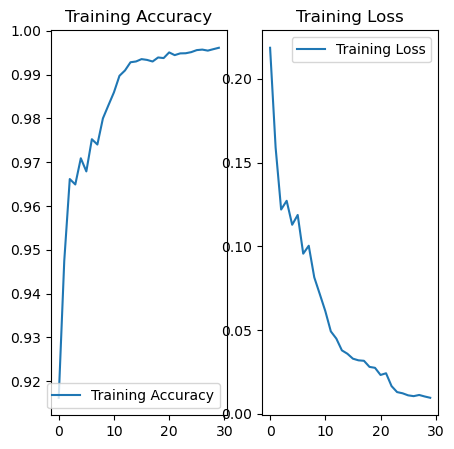

In [9]:
def learning_curves(history):
    acc = history.history['sparse_categorical_accuracy']
    loss = history.history['loss']
    epochs_range = history.epoch

    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')
    plt.show()
    
learning_curves(history)

### Un super Mask !!!